# Custom Analysis of Training Results

Notebook demonstrates two methods for plotting training results.  First method uses Ludwig's visualization api.  Second method illustrates converting Ludwig training statistics into a pandas dataframe and plotting data with seaborn package.

This notebook is dependent on running the multiple model training example beforehand.  To run the mulitple model training example, enter this command:
``` 
python multiple_model_training.py
```

## Import required libraries

In [1]:
from ludwig.utils.data_utils import load_json
from ludwig.visualize import learning_curves
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns

## Generate Annotated Learning Curves Using Ludwig Visualization API

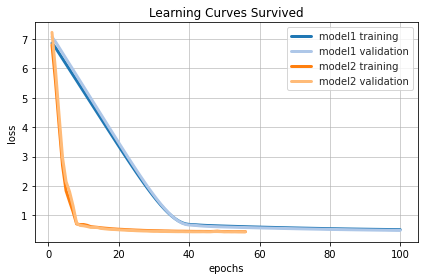

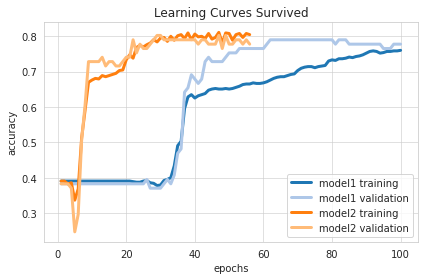

In [2]:
# retrieve training statistics
list_of_stats = []
list_of_models = []

for model in ['model1', 'model2']:
    experiment_model_dir = './results/multiple_experiment_' + model 
    train_stats = load_json(os.path.join(experiment_model_dir,'training_statistics.json'))
    list_of_stats.append(train_stats)
    list_of_models.append(model)
    

# generating learning curves from training
learning_curves(list_of_stats, 'Survived',
                model_names=list_of_models,
                output_directory='./visualizations',
                file_format='png')


## Generate Annotated Learning Curves Using seaborn package

### Helper function to collect training statistics

In [3]:
# function to generate pandas data frame from training statistcs
# Parameter:
#   experiment_model_dir: directory containing the training statistics for a specific model training experiment
#
# Returns: pandas dataframe containing the performance metric and loss
#

def extract_training_stats(experiment_model_dir):
    list_of_splits = ['training', 'validation', 'test']
    list_of_df = []
    for split in list_of_splits:
        train_stats = load_json(os.path.join(experiment_model_dir,'training_statistics.json'))
        df = pd.DataFrame(train_stats[split]['combined'])
        df.columns = [split + '_' + c for c in df.columns]
        list_of_df.append(df)
        
    df = pd.concat(list_of_df, axis=1)
    df['epoch'] = df.index + 1
        
    return df

### Retrieve training results

In [4]:
model1 = extract_training_stats('./results/multiple_experiment_model1')
model1.name = 'model1'
model2 = extract_training_stats('./results/multiple_experiment_model2')
model2.name = 'model2'

In [5]:
model1.head()

,training_loss,validation_loss,test_loss,epoch
0,6.646716,7.069627,7.541213,1
1,6.495552,6.909096,7.370474,2
2,6.315707,6.718051,7.167351,3
3,6.135415,6.526596,6.963694,4
4,5.954975,6.334948,6.759850,5


### Helper function to generate plot ready data

In [6]:
# create pandas dataframe suitable for plotting learning curves
# Parameters
#   train_df_list: list of pandas datatframe containing training statistics
#
# Returns: plot ready pandas dataframe

def create_plot_ready_data(list_of_train_stats_df):
    # holding ready for plot ready data
    plot_ready_list = []
    
    # consolidate the multiple training statistics dataframes
    for df in list_of_train_stats_df:
        for col in ['training', 'validation']:
            df2 = df[['epoch', col + '_loss']].copy()
            df2.columns = ['epoch', 'loss']
            df2['type'] = col
            df2['model'] = df.name
            plot_ready_list.append(df2)

    return pd.concat(plot_ready_list, axis=0, ignore_index=True)


### Plot learning curves

In [7]:
# create plot ready data
learning_curves = create_plot_ready_data([model1, model2])

Text(0.5, 1.0, 'Learning Curves')

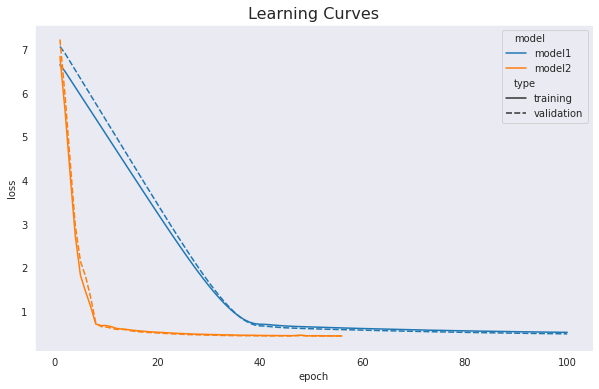

In [8]:
# Plot learning curves for the different models
fig = plt.figure(figsize=(10,6))
sns.set_style(style='dark')
ax = sns.lineplot(x='epoch', y='loss',
             style='type',
             hue='model',
             data=learning_curves)
ax.set_title('Learning Curves', fontdict={'fontsize': 16})

In [9]:
fig.savefig('./visualizations/custom_learning_curve.png')